#  Loading the dataset 

In [1]:
from __future__ import print_function, division
from sklearn.datasets import load_digits
digits = load_digits ()
print(list(digits.keys()))
data = digits["data"]
images = digits["images"]
target = digits["target"]
target_names = digits["target_names"]
import numpy as np
from scipy.sparse.linalg import lsqr

['DESCR', 'target_names', 'images', 'data', 'target']


In [2]:
# Create feature matrix X and groundtruth y
y = target[(target == 3) | (target == 8)]
y[y == 3] = 1
y[y == 8] = -1
images_ = images[(target == 3) | (target == 8)]
X = data[(target == 3) | (target == 8)]
np.shape(X)

(357, 64)

# Basic functions

In [3]:
def sigmoid(Z):
    return 1./(1.+np.exp(-Z))

def gradient(beta,X,y):
    return np.sum((-y[:,np.newaxis]*X) *(1-sigmoid(y[:,np.newaxis]*np.dot(X,beta[:,np.newaxis]))),0)/y.shape

def predict(beta,X):
    return np.sign(np.dot(X,beta))

def zero_one_loss(y_p,y_g):
    return np.sum(y_p != y_g) / float(len(y_p))

# Optimization Method

SGD and its variants use sampling without replacement. It reduces the number of sampling calls by shuffling an index array only once per epoch and simplifies slicing in mini batch versions.

In [4]:
SEED = 1 # make stochastic methods repeatable

def gradient_descent(beta, X, y, tau, m=10,):
    betas = []
    for t in range(m):
        beta = beta - tau * gradient(beta, X, y)
        betas.append(beta)
    return beta, np.asarray(betas)

def stochastic_gradient_descent(beta, X, y, tau_0, gamma=1, m=150):
    np.random.seed(SEED)
    betas = []
    tau = tau_0
    n = len(y)
    indexx = np.arange(n)
    for t in range(m):
        i = np.mod(t, n) # np modulus returns 0 if divisor = 0
        if i == 0:
            np.random.shuffle(indexx)
        beta = beta - tau*gradient(beta, X[indexx[i]], y[indexx[i]:indexx[i]+1])
        betas.append(beta)
        tau = tau_0 / (1 + t*gamma)
    return beta, np.asarray(betas)


def stochastic_gradient_mini(beta, X, y, tau_0, gamma=1, m=150, b=30):
    betas = []
    np.random.seed(SEED)
    tau = tau_0
    n = len(y)
    indexx = np.arange(n)
    np.random.shuffle(indexx)
    rest = np.mod(n, b)
    multpl = (n-rest) / b
    for t in range(m):
        tb = np.mod(t, multpl+1)
        if tb == multpl:
            # every last minibatch per epoch gets filled with random samples
            i = np.append(indexx[b*tb:], np.random.randint(n, size=rest))
            np.random.shuffle(indexx)
        else:
            i = indexx[b*tb:b*(tb+1)]
        beta = beta - tau*gradient(beta,X[i],y[i])
        betas.append(beta)
        tau = tau_0/(1 + t*gamma)
    return beta, np.asarray(betas)
                                              
def stochastic_gradient_mom(beta, X, y, tau_0, mu=0.3,gamma=1, m=150):
    betas = []
    np.random.seed(SEED)
    tau = tau_0
    n = len(y)
    g = 0
    indexx = np.arange(n)
    for t in range(m):
        i = np.mod(t, n) # np modulus returns 0 if divisor = 0
        if i == 0:
            np.random.shuffle(indexx)
        g = mu * g + (1 - mu) * gradient(beta, X[indexx[i]], y[indexx[i]:indexx[i]+1])
        beta = beta - tau*g
        betas.append(beta)
        tau = tau_0 / (1 + t*gamma)
    return beta, np.asarray(betas)                          
                          
def average_stochastic_gradient(beta, X, y, tau_0, mu, gamma=1, m=150):
    betas = []
    np.random.seed(SEED)
    tau = tau_0
    n = len(y)
    g = 0
    indexx = np.arange(n)
    for t in range(m):
        i = np.mod(t, n)
        if i == 0:
            np.random.shuffle(indexx)
        g -= tau * gradient(beta, X[indexx[i]], y[indexx[i]:indexx[i]+1])
        beta = (1 - mu) * beta + mu * g
        betas.append(beta)
        tau = tau_0 / np.power(1 + t*gamma,3/4)
    return beta, np.asarray(betas)
    
def stochastic_average_gradient(beta, X, y, tau_0, m=150, gamma=1):  # Roux et al. [2012]
    np.random.seed(SEED)
    betas = []
    tau = tau_0
    n = len(y)
    indexx = np.arange(n)
    gradients = np.zeros((n, beta.size))
    for t in range(n):
        i = np.mod(n, t)
        if i == 0:
            np.random.shuffle(indexx)
        gradients[indexx[i]] = gradient(
                        beta, X[indexx[i]], y[indexx[i]:indexx[i]+1])
        beta = beta - tau*gradients.mean(axis=0)
        betas.append(beta)
        tau = tau_0 / (1 + t*gamma)
    return beta, np.asarray(betas)
        
        
def dual_coordinate_ascent(beta,X,y,tau_0=0.1,gamma=0.01,m = 150):
    np.random.seed(SEED)
    betas = []
    n = len(y)
    a = np.random.rand(n)
    a_ = np.copy(a)
    beta =np.sum(a[:,np.newaxis]*y[:,np.newaxis]*X,0)
    indexx = np.arange(n)
    Z =np.dot(X,X.transpose())
    for t in range(m):   
        i = np.mod(t,n)
        a_[indexx[i]] = np.clip(a[indexx[i]]-y[indexx[i]:indexx[i]+1]*np.dot(X[indexx[i]],beta)
                                / Z[indexx[i],indexx[i]], 0,1) # add formula 
        beta = beta+(a_[indexx[i]]-a[indexx[i]])*y[indexx[i]:indexx[i]+1]*X[indexx[i],:]
        betas.append(beta)
        a[indexx[i]] = a_[indexx[i]]
    return beta, np.asarray(betas)

def weighted_least_squares(beta,X,y,m=10):
    betas = []
    for t in range(0, m):
        z = np.dot(X,beta[:,np.newaxis])
        V = np.zeros([len(z), len(z)])
        y_tilde = np.zeros([len(z)])
        for i_prime in range(len(z)):
            V[i_prime, i_prime] = np.sqrt(1. / len(z) * sigmoid(z[i_prime]) * (1-sigmoid(z[i_prime])))
            y_tilde[i_prime] = y[i_prime] / sigmoid(y[i_prime]*z[i_prime])
        z_tilde = np.dot((z + y_tilde[:, np.newaxis]).T, V)
        X_tilde = np.dot(V,X)
        
        # use scipy lsqr to solve argmin_{\beta}(z_tilde-X_tilde*\beta)^2
        ls_obj = lsqr(X_tilde, z_tilde)
        beta = np.reshape(ls_obj[0], beta.shape)
        betas.append(beta)
    return beta, np.asarray(betas)

# 2.3 Comparison
Learning Rate
--

In [7]:
from sklearn import cross_validation
from itertools import product

X, X_test, y, y_test = cross_validation.train_test_split(X, y,
                                            random_state=0, test_size=0.3)
taus = [0.001, 0.01, 0.1]
mus = [0.1, 0.2, 0.5]
gammas = [0.0001, 0.001, 0.01]

In [8]:
kf = cross_validation.KFold(y.shape[0], n_folds=10)

def opt_params(kf, optimizer, values):
    best_error = 5000 # ok bc/ zero_one_loss limits to number of samples
    for combination in product(*values):
        error = 0        
        for train_index, validation_index in kf:
            X_train, X_validation = X[train_index], X[validation_index]
            y_train, y_validation = y[train_index], y[validation_index]
            beta = np.zeros(X_train[0,:].shape)
            b, history = optimizer(beta, X_train, y_train, *combination)
            error += zero_one_loss(predict(b, X_validation), y_validation) / len(kf)
#         print((combination, error))
        if error < best_error:
            best_error = error
            best_params = combination
    return best_error, best_params

### Gradient Descent

In [9]:
gd_error, gd_params = opt_params(kf, gradient_descent, [taus])
print(gd_params, gd_error)

(0.001,) 0.0464052287582


### SGD

In [10]:
sgd_error, sgd_params = opt_params(kf, stochastic_gradient_descent, [taus, gammas])
print(sgd_params, sgd_error)

(0.01, 0.001) 0.0346405228758


### SGD Minibatch


In [11]:
mini_error, mini_params = opt_params(kf, stochastic_gradient_mini, [taus, gammas])
print(mini_params, mini_error)

(0.01, 0.0001) 0.00588235294118


/home/tg/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:42: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/tg/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:39: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


### SGD Momentum

In [12]:
mom_error, mom_params = opt_params(kf, stochastic_gradient_mom, [taus, mus, gammas])
print(mom_params, mom_error)

(0.01, 0.1, 0.001) 0.0117647058824


### Average Stochastic Gradient

In [13]:
asg_error, asg_params = opt_params(kf, average_stochastic_gradient, [taus, mus, gammas])
print(asg_params, asg_error)

(0.01, 0.1, 0.01) 0.0228758169935


### Stochastic Average Gradient

In [14]:
sag_error, sag_params = opt_params(kf, stochastic_average_gradient, [taus, gammas])
print(sag_params, sag_error)

(0.1, 0.0001) 0.0633986928105


/home/tg/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:90: RuntimeWarning: divide by zero encountered in remainder


### Dual Coordinate Ascent

In [15]:
dca_error, dca_params = opt_params(kf, dual_coordinate_ascent, [taus, gammas])
print(dca_params, dca_error)

(0.001, 0.0001) 0.167647058824


### WLSQR

In [16]:
wlsq_error, wlsq_params = opt_params(kf, weighted_least_squares, [])
print(wlsq_params, wlsq_error)

() 0.040522875817


## Overview optimal parameters:

|Method|#iterations|minimal Error|$\tau$ or $ \tau_0$|$\mu$|$\gamma$|
|---|:---:|:---:|:---:|:---:|:---:|
|Gradient Descent|10|0.046|0.001|-|-|
|Stochastic GD|150|0.035|0.01|-|0.001|
|SGD minibatch|150|0.0059|0.01|-|0.0001|
|SGD momentum|150|0.0118|0.01|0.1|0.001|
|Average SG|150|0.023|0.01|0.1|0.01|
|Stochastic Average Gradient|150|0.063|0.1|-|0.0001|
|Dual Coordinate Ascent|150|0.168|0.001|-|0.0001|
|Weighted Least Squares|10|0.041|-|-|-|

Speed
---

In [17]:
import matplotlib.pyplot as plt

def error(X, y, history):
    errors = []
    for beta in history:
        prediction = predict(beta, X)
        errors.append(zero_one_loss(y, prediction))
    return np.array(errors)
methods = [
gradient_descent, stochastic_gradient_descent, stochastic_gradient_mini,
stochastic_gradient_mom, average_stochastic_gradient, stochastic_average_gradient,
dual_coordinate_ascent, weighted_least_squares
]

gd = X[0,:].size
sgd = y.size * gd
wlsq = y.size * gd**2
mb = 30 * gd

beta0 = np.zeros(gd)

scaling = [gd, sgd, mb, sgd, sgd, sgd, sgd, wlsq] 
params = [gd_params, sgd_params, mini_params, mom_params, asg_params,
         sag_params, dca_params, wlsq_params]

histories = [method(beta0, X, y, *params)[1] for method, params in zip(methods, params)]
train_errors = [error(X,y,history) for history in histories]
test_errors = [error(X_test, y_test, history) for history in histories]
names = ['gradient descent', 'SGD', 'minibatch SGD', 'SGD + momentum',
         'ASG', 'SAG', 'Dual', 'wlsq']

/home/tg/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:42: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/tg/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:39: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/tg/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:90: RuntimeWarning: divide by zero encountered in remainder


In [20]:
%matplotlib notebook


<IPython.core.display.Javascript object>


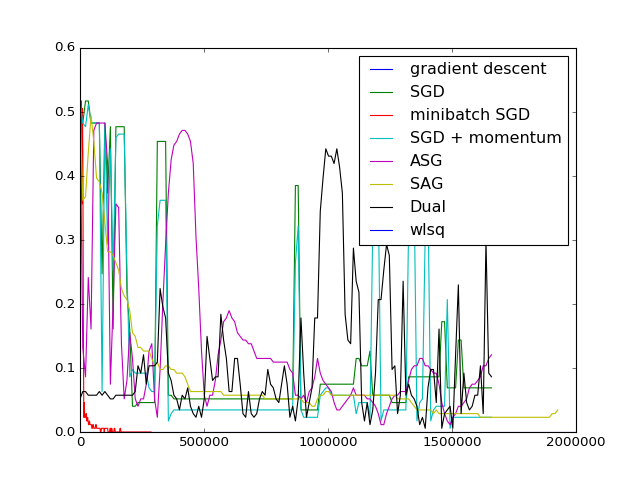

In [21]:
for i in range(len(histories)):
    y = train_errors[i]
    x = np.arange(len(y)) * scaling[i]
    plt.plot(x, y, label=names[i])
    plt.xlim((0, 2000000))
plt.legend()
plt.show()
    

<IPython.core.display.Javascript object>


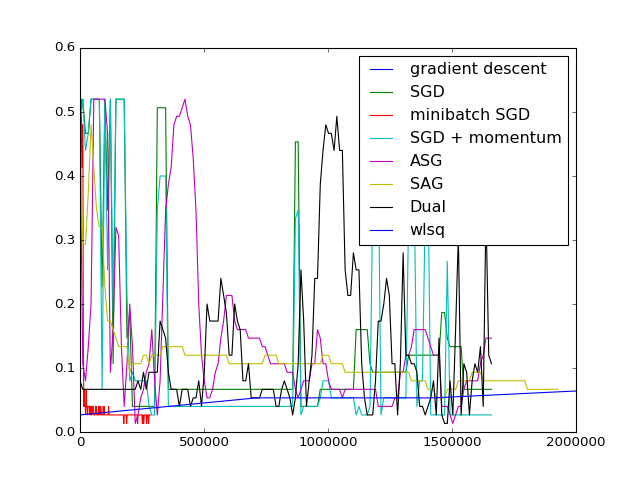

In [22]:
for i in range(len(histories)):
    y = test_errors[i]
    x = np.arange(len(y)) * scaling[i]
    plt.plot(x, y, label=names[i])
    plt.xlim((0, 2000000))
plt.legend()
plt.show()